In [1]:
import os, requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import shuffle
from warnings import filterwarnings
filterwarnings('ignore')
import random
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Download Data

In [2]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
    
fname.append('steinmetz_st.npz')
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")
url.append("https://osf.io/4bjns/download")
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

In [3]:
alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']

In [4]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

## Functions

In [5]:
def preprocess_data(data):
    spks = data['spks']
    response_time = data['response_time']
    feedback_type = data['feedback_type']
    pupil = np.sum(data['pupil'][0], axis=1)
    wheel = np.sum(np.squeeze(np.abs(data['wheel'])), axis=1)
    VISp = dat_LFP[11]['lfp'][3].mean(axis=1)
    VISam = dat_LFP[11]['lfp'][11].mean(axis=1)
    ACA = dat_LFP[11]['lfp'][4].mean(axis=1)
    
    # go response only
    go = ~np.logical_and(data['contrast_right'] == 0, data['contrast_left'] == 0)
    contrast_left = data['contrast_left']
    contrast_right = data['contrast_right']
    response =  np.abs(data['response']) == 1 
    contrast_diff_response = np.abs(contrast_left - contrast_right)*response.astype(int)*go.astype(int)

    # visual cortex only
    keep_neurons = []
    for ii,barea in enumerate(dat['brain_area']):
        if (barea in brain_groups[0]):
            keep_neurons.append(ii)
            
    # first 80 time bins 
    spks = spks[keep_neurons,:,50:130]

    # easy and difficult trials only 
    easy_trials = contrast_diff_response == 0.75
    difficult_trials = contrast_diff_response == 0.25
    easy = np.where(easy_trials)
    difficult = np.where(difficult_trials)

    easy_labels = np.zeros((easy[0].shape))
    difficult_labels = np.ones((difficult[0].shape))
    easy_difficult_trials = np.concatenate((easy,difficult), axis=None)
    X = spks[:,easy_difficult_trials,:]
    feedback_type = feedback_type[easy_difficult_trials]
    X_response_time = response_time[easy_difficult_trials]
    X_pupil = pupil[easy_difficult_trials]
    X_wheel = wheel[easy_difficult_trials]
    VISp = VISp[easy_difficult_trials]
    VISam = VISam[easy_difficult_trials]
    ACA = ACA[easy_difficult_trials]
    
    X_3d = X
    X_2d = X.reshape((X.shape[1],X.shape[0]*X.shape[2]))
    labels = np.concatenate((easy_labels, difficult_labels), axis=None)
    
    return X_3d, X_2d, labels, X_response_time, X_pupil, X_wheel, VISp, VISam, feedback_type, ACA

In [6]:
# logistic regression
def logistic_reg(X,y):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    accs_all = []
    sem_all = []
    regs = ['l2','l1','elasticnet']
    for ii,reg in enumerate(regs):
        accs = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if reg=='elasticnet':
                lr = LogisticRegression(penalty=reg, l1_ratio=0.2, solver='saga')
            else:
                lr = LogisticRegression(penalty=reg, solver='saga')
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accs.append(acc)
        accs_all.append(np.mean(accs))
        sem = stats.sem(accs)
        sem_all.append(sem)
    return accs_all, sem_all

# random forest
def random_forest(X,y):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    accs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
    return np.mean(accs), stats.sem(accs)

# k nearest neighbors
def knn(X,y):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    accs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        neigh = KNeighborsClassifier(n_neighbors=2)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
    return np.mean(accs), stats.sem(accs)

# SVM
def support_vector(X,y):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    accs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = svm.SVC(kernel='linear') # Linear Kernel
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
    return np.mean(accs), stats.sem(accs)

## Session 11 Only

In [7]:
dat = alldat[11]

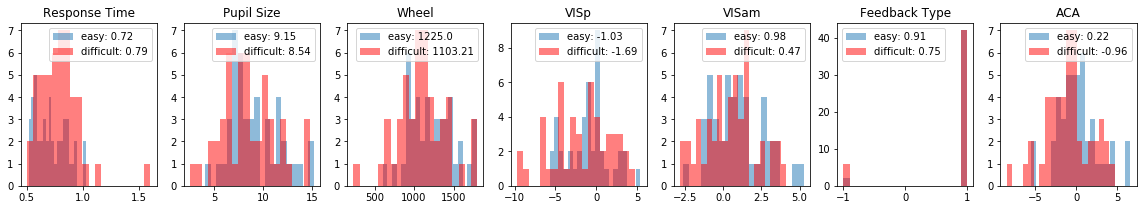

In [8]:
def plot_histogram(data, title=None, ax=None):
    easy = np.where(y==0)[0]
    difficult = np.where(y==1)[0]
    easy_mean = np.round(data[easy].mean(),2)
    difficult_mean = np.round(data[difficult].mean(),2)
    ax.hist(data[easy], label='easy: {}'.format(easy_mean), bins=20, alpha=0.5)
    ax.hist(data[difficult], label='difficult: {}'.format(difficult_mean), bins=20, alpha=0.5, color='red')
    ax.set_title(title)
    ax.legend()

X_3d, X_2d, y, X_response_time, X_pupil, X_wheel, VISp, VISam, feedback_type, ACA = preprocess_data(dat)

titles = ['Response Time', 'Pupil Size', 'Wheel', 'VISp', 'VISam', 'Feedback Type', 'ACA']
datas = [X_response_time, X_pupil, X_wheel, VISp, VISam, feedback_type, ACA]
fig, ax = plt.subplots(1, len(titles), figsize=(20,3))
for data,title,i in zip(datas, titles, range(len(titles))):
    ax[i] = plot_histogram(data, title, ax=ax[i])


In [9]:
# with PCA n=10
X_3d, X_2d, labels, X_response_time, X_pupil, X_wheel, VISp, VISam, feedback_type, ACA = preprocess_data(dat)
X_pca = PCA(n_components=10).fit_transform(X_2d)
X_pca = np.hstack((X_pca, X_response_time))
X_pca, y = shuffle(X_pca, labels)
scaler = StandardScaler()
X = scaler.fit_transform(X_pca)
np.savez('data_11_pca.npz', data=X, labels=y)

In [17]:
# without PCA, take mean across neurons and time points for spikes
X_3d, X_2d, labels, X_response_time, X_pupil, X_wheel, VISp, VISam, feedback_type, ACA = preprocess_data2(dat)
X = X_3d.mean(axis=0).mean(axis=1)
X = X[...,np.newaxis]
X = np.hstack((X, X_response_time))
X, y = shuffle(X, labels)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# true labels
lr_acc, lr_sem = logistic_reg(X,y)
rf_acc, rf_sem = random_forest(X,y)
knn_acc, knn_sem = knn(X,y)
svm_acc, svm_sem = support_vector(X,y)

# random labels
random.shuffle(y)
lr_acc_random, lr_sem_random = logistic_reg(X,y)
rf_acc_random, rf_sem_random = random_forest(X,y)
knn_acc_random, knn_sem_random = knn(X,y)
svm_acc_random, svm_sem_random = support_vector(X,y)

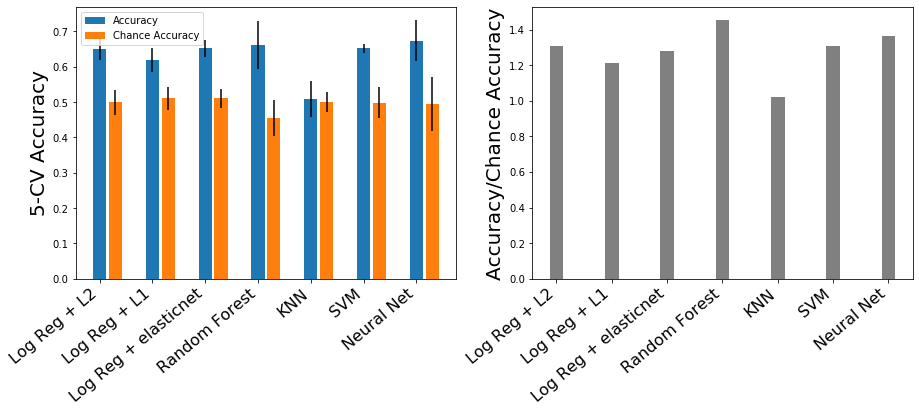

In [11]:
# accuracy plots 

fig, ax = plt.subplots(1,2, figsize=(15,5))
models = ['Log Reg + L2', 'Log Reg + L1', 'Log Reg + elasticnet', 'Random Forest', 'KNN', 'SVM', 'Neural Net']
mlp_acc, mlp_sem = 0.6736842105263158, 0.05860804592452653
mlp_acc_random, mlp_sem_random = 0.4947368421052632, 0.07554052681267012
accs = [lr_acc[0], lr_acc[1], lr_acc[2], rf_acc, knn_acc, svm_acc, mlp_acc]
errors = [lr_sem[0], lr_sem[1], lr_sem[2], rf_sem, knn_sem, svm_sem, mlp_sem]
accs_random = [lr_acc_random[0], lr_acc_random[1], lr_acc_random[2], rf_acc_random, knn_acc_random, svm_acc_random, mlp_acc_random]
errors_random = [lr_sem_random[0], lr_sem_random[1], lr_sem_random[2], rf_sem_random, knn_sem_random, svm_sem_random, mlp_sem_random]

X = np.arange(7)
ax[0].bar(X, accs, yerr=errors, label='Accuracy', width=0.25)
ax[0].bar(X+0.3, accs_random, yerr=errors_random, label='Chance Accuracy', width=0.25)
ax[0].set_ylabel('5-CV Accuracy', fontsize=20)
ax[0].set_xticks(X)
ax[0].set_xticklabels(models, rotation=40, fontsize=16, ha='right')
ax[0].legend()

acc_over_chance = np.divide(accs, accs_random)
ax[1].bar(X, acc_over_chance, width=0.25, color='grey')
ax[1].set_ylabel('Accuracy/Chance Accuracy', fontsize=20)
ax[1].set_xticks(X)
ax[1].set_xticklabels(models, rotation=40, fontsize=16, ha='right')
#plt.savefig('/Users/ahyeon/Desktop/data_11_pca_acc.pdf', bbox_inches='tight')

plt.show()


## All sessions 

In [12]:
# remove forssmann (35 sessions)

remove_dat = []
for i in range(len(alldat)):
    dat = alldat[i]
    mouse = dat['mouse_name']
    if mouse == 'Forssmann':
        remove_dat.append(i) 
        
newdat = [i for j, i in enumerate(alldat) if j not in remove_dat] 

In [13]:
# Concatenate 10 sessions

all_X = []
all_y = []
all_names = []
for i in range(len(newdat)):
    dat = newdat[i]
    spks = dat['spks']
    response_time = dat['response_time']
    pupil = np.sum(dat['pupil'][0], axis=1)
    
    go = ~np.logical_and(dat['contrast_right'] == 0, dat['contrast_left'] == 0)
    contrast_left = dat['contrast_left']
    contrast_right = dat['contrast_right']
    response =  np.abs(dat['response']) == 1 
    contrast_diff_response = np.abs(contrast_left - contrast_right)*response.astype(int)*go.astype(int)

    keep_neurons = []
    for ii,barea in enumerate(dat['brain_area']):
        if (barea in brain_groups[0]):
            keep_neurons.append(ii)
    random.shuffle(keep_neurons)
    spks = spks[keep_neurons[:140],:,50:130]

    easy_trials = contrast_diff_response == 0.75
    difficult_trials = contrast_diff_response == 0.25    
    easy = np.where(easy_trials)
    difficult = np.where(difficult_trials)
    easy_labels = np.zeros((easy[0].shape))
    difficult_labels = np.ones((difficult[0].shape))
    easy_difficult_trials = np.concatenate((easy,difficult), axis=None)
    
    X = spks[:,easy_difficult_trials,:]
    X_response_time = response_time[easy_difficult_trials]
    X_pupil = pupil[easy_difficult_trials]
        
    num_trials = X.shape[1]
    num_neurons = X.shape[0]
    if ((num_neurons >= 140) & (num_trials >= 30)):
        X_2d = X.reshape((X.shape[1],X.shape[0]*X.shape[2]))
        X_2d = np.hstack((X_2d, X_response_time))
        labels = np.concatenate((easy_labels, difficult_labels), axis=None)
        
        print('easy: {}'.format(len(easy_labels)),'difficult: {}'.format(len(difficult_labels)),
                                'total_trials: {}'.format(len(labels)),dat['mouse_name'])

        all_X.append(X_2d)
        all_y.append(labels)
        all_names.append(dat['mouse_name'])

easy: 25 difficult: 17 total_trials: 42 Cori
easy: 17 difficult: 19 total_trials: 36 Cori
easy: 21 difficult: 11 total_trials: 32 Cori
easy: 41 difficult: 35 total_trials: 76 Hench
easy: 35 difficult: 43 total_trials: 78 Hench
easy: 44 difficult: 48 total_trials: 92 Lederberg
easy: 12 difficult: 20 total_trials: 32 Moniz
easy: 19 difficult: 25 total_trials: 44 Moniz
easy: 14 difficult: 16 total_trials: 30 Radnitz
easy: 26 difficult: 43 total_trials: 69 Theiler


In [14]:
# with PCA
X_concat = np.concatenate(all_X, axis=0)
y_concat = np.concatenate(all_y, axis=0)
X, y = shuffle(X_concat, y_concat)
X_pca = PCA(n_components=10).fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X_pca)

np.savez('data_all_pca.npz', data=X, labels=y)

In [15]:
# true labels
lr_acc, lr_sem = logistic_reg(X,y)
rf_acc, rf_sem = random_forest(X,y)
knn_acc, knn_sem = knn(X,y)
svm_acc, svm_sem = support_vector(X,y)

# random labels
random.shuffle(y)
lr_acc_random, lr_sem_random = logistic_reg(X,y)
rf_acc_random, rf_sem_random = random_forest(X,y)
knn_acc_random, knn_sem_random = knn(X,y)
svm_acc_random, svm_sem_random = support_vector(X,y)

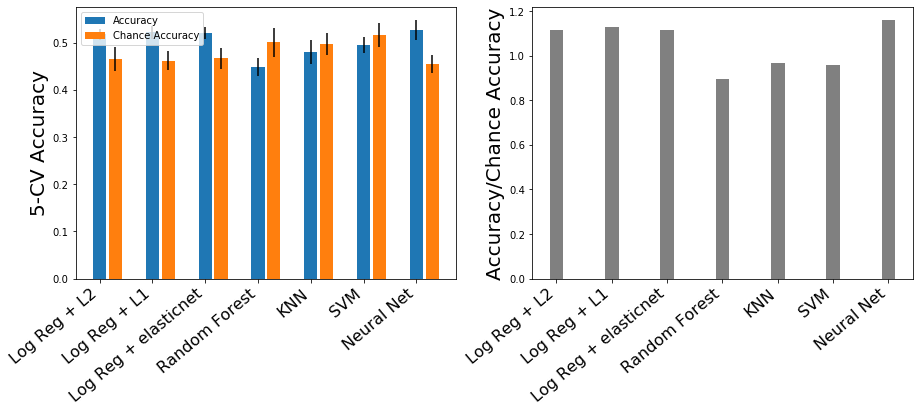

In [16]:
# all sessions 

fig, ax = plt.subplots(1,2, figsize=(15,5))
models = ['Log Reg + L2', 'Log Reg + L1', 'Log Reg + elasticnet', 'Random Forest', 'KNN', 'SVM', 'Neural Net']
mlp_acc, mlp_sem = 0.5271028037383176, 0.020814072384411287
mlp_acc_random, mlp_sem_random = 0.4542056074766355, 0.019737114095273716
accs = [lr_acc[0], lr_acc[1], lr_acc[2], rf_acc, knn_acc, svm_acc, mlp_acc]
errors = [lr_sem[0], lr_sem[1], lr_sem[2], rf_sem, knn_sem, svm_sem, mlp_sem]
accs_random = [lr_acc_random[0], lr_acc_random[1], lr_acc_random[2], rf_acc_random, knn_acc_random, svm_acc_random, mlp_acc_random]
errors_random = [lr_sem_random[0], lr_sem_random[1], lr_sem_random[2], rf_sem_random, knn_sem_random, svm_sem_random, mlp_sem_random]

X = np.arange(7)
ax[0].bar(X, accs, yerr=errors, label='Accuracy', width=0.25)
ax[0].bar(X+0.3, accs_random, yerr=errors_random, label='Chance Accuracy', width=0.25)
ax[0].set_ylabel('5-CV Accuracy', fontsize=20)
ax[0].set_xticks(X)
ax[0].set_xticklabels(models, rotation=40, fontsize=16, ha='right')
ax[0].legend()

acc_over_chance = np.divide(accs, accs_random)
ax[1].bar(X, acc_over_chance, width=0.25, color='grey')
ax[1].set_ylabel('Accuracy/Chance Accuracy', fontsize=20)
ax[1].set_xticks(X)
ax[1].set_xticklabels(models, rotation=40, fontsize=16, ha='right')
#plt.savefig('/Users/ahyeon/Desktop/data_all_pca_acc.pdf', bbox_inches='tight')

plt.show()
